In [15]:
import numpy as np
import pandas as pd
import polars as pl

from collections import deque, defaultdict
import ast
import os
import glob
from pathlib import Path
from scipy.stats import mode
from modeling_parameters.config import (
    MATPLOTLIBRC_PATH,
    COORDINATES_PATH,
    CENTRAL_STATIONS,
)

import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from modeling_parameters.reconstruction.geant.functions import(
     compute_r,
     rho_model,
     filter_clusters,
)

from functions import(
    ast_df,
    ast_modeling_df,
    is_central_stations,
)

from config import(
    converters,
    columns_to_eval,
)


In [16]:
coordinates_df = pd.read_csv(COORDINATES_PATH)

X_det = np.array(coordinates_df['X'])
Y_det = np.array(coordinates_df['Y'])
Z_det = np.array(coordinates_df['Z'])

In [17]:
geant_data_dir = 'geant_data'
wich_data = 'spe'
filter_geant_1_file = 'spe27p_theta_ge_40.parquet'
filter_geant_2_file = 'spe27p1416_theta_ge_40.parquet'
filter_geant_2_filepath  = os.path.join(geant_data_dir,wich_data, filter_geant_2_file)


In [18]:
geant2_df = pd.read_parquet(filter_geant_2_filepath)

In [22]:
geant2_df.head(1)

,N_event,NRUN,NEVENT,PART0,E0,Teta,Fi,XAxisShift,YAxisShift,H1INT,...,nTrackSMY0,nTrackSM0,EdepCntSCT,EdepDetNE,TimDetNE,EdepStNE,TimStNE,marker,r_vals,rho_vals
0,5.0,100.0,6.0,14.0,326163.03125,42.334309,91.275635,23.088896,-3.263381,2077692.75,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[0.0, 0.0, 0.0, 0.0], [0.0, 1.38472855091094...",[[[[ 0.00000000e+00 -1.00000000e+00 1.0000000...,"[[0.0, 1.3847285509109497, 0.39429834485054016...","[[[0.0, -1.0, 1.0000000200408773e+20, 0.0], [9...",-1.0,"[32.03541109066071, 18.08120471954615, 18.7454...","[2.088209841309524, 0.32725927942409744, 0.478..."


In [23]:
theta_arr = np.array(np.array(geant2_df['Teta']))
Ne_arr = np.array(np.array(geant2_df['NeNKGlong']))

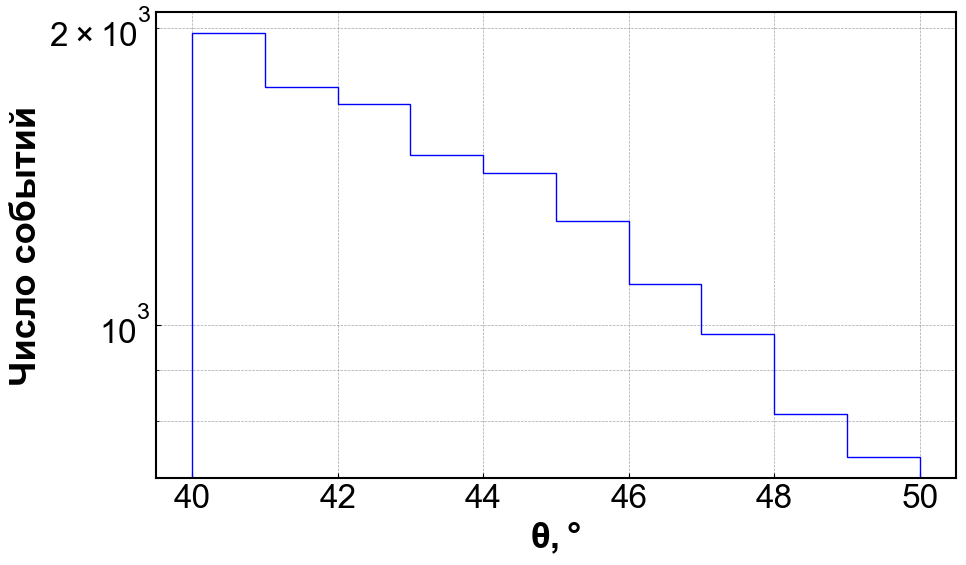

In [24]:

bins = 10
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(theta_arr, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'$\theta,\degree$')
plt.ylabel('Число событий')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

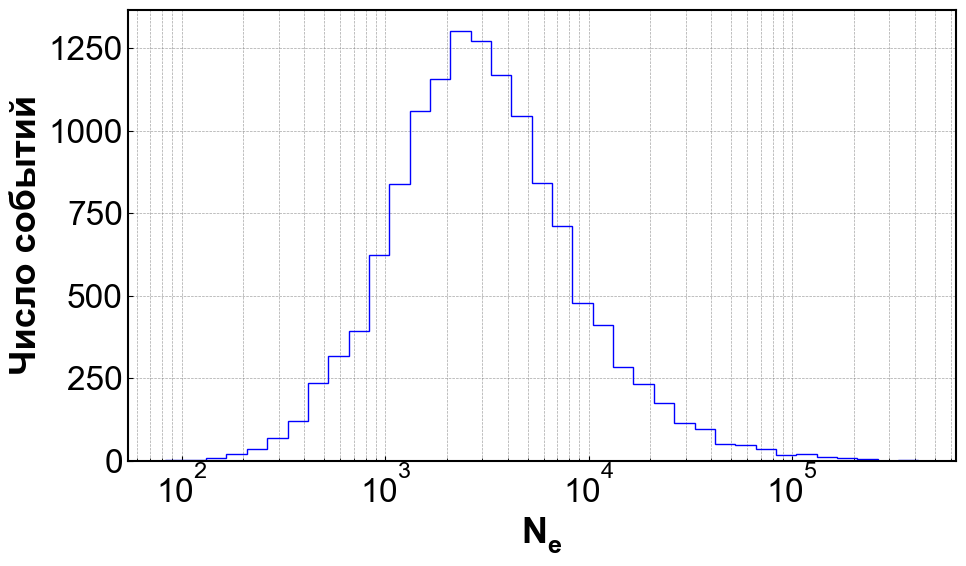

In [25]:



log_min = np.log10(Ne_arr.min())
log_max = np.log10(Ne_arr.max())
log_bins = np.arange(log_min, log_max + 0.1, 0.1) 
bins = 10 ** log_bins  

plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(Ne_arr, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'$N_e$')
plt.ylabel('Число событий')
plt.xscale('log')
plt.yscale('linear')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
geant2_ne_e4_df = geant2_df[
    (geant2_df['NeNKGlong'] < 1e5) & (geant2_df['NeNKGlong'] > 1e4)
]

In [38]:
r_rho_pairs = [
    (r, rho)
    for r_list, rho_list in zip(geant2_ne_e4_df["r_vals"], geant2_ne_e4_df["rho_vals"])
    if isinstance(r_list, (list, np.ndarray)) and isinstance(rho_list, (list, np.ndarray))
    for r, rho in zip(r_list, rho_list)
]

r_geant2, rho_geant2 = map(np.array, zip(*r_rho_pairs))

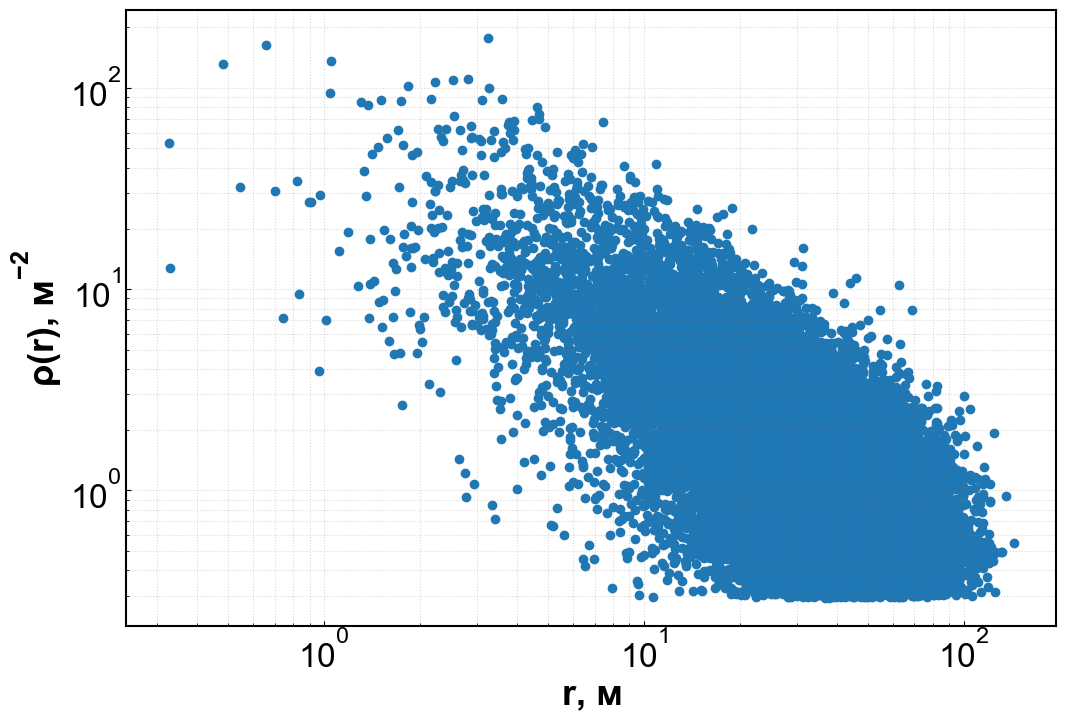

In [40]:
plt.figure(figsize=(12, 8))

plt.scatter(r_geant2, rho_geant2)


plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls=':')
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\rho(r)$, м$^{-2}$')
# plt.legend()
plt.show()


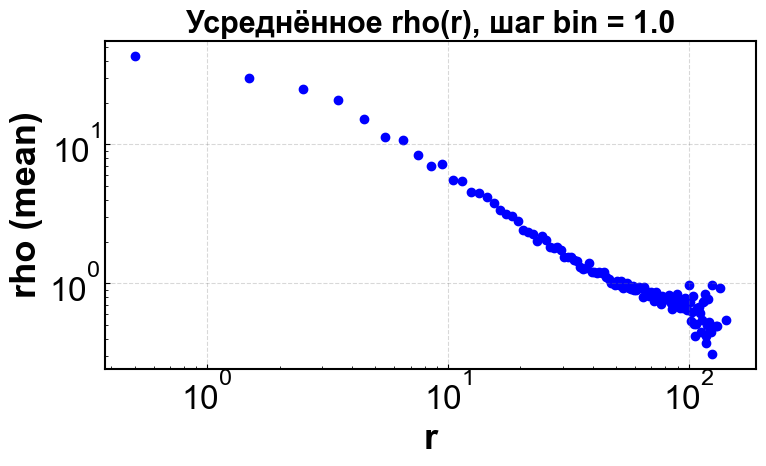

In [45]:
step = 1.0

# Определяем диапазон r
r_min = np.floor(r_geant2.min())
r_max = np.ceil(r_geant2.max())

# Создаём бин границы
bins = np.arange(r_min, r_max + step, step)

# Получаем индексы бинов для каждого значения r
bin_indices = np.digitize(r_geant2, bins)

# Вычисляем среднее rho для каждого бина
rho_means = []
r_centers = []

for i in range(1, len(bins)):
    in_bin = bin_indices == i
    if np.any(in_bin):  # если есть хотя бы один элемент в этом бине
        rho_means.append(rho_geant2[in_bin].mean())
        # Центр бина
        r_centers.append((bins[i - 1] + bins[i]) / 2)

# Переводим в массивы
r_centers = np.array(r_centers)
rho_means = np.array(rho_means)

plt.figure(figsize=(8, 5))
plt.scatter(r_centers, rho_means, color='blue')
plt.xlabel('r')
plt.ylabel('rho (mean)')
plt.title(f'Усреднённое rho(r), шаг bin = {step}')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()